In [2]:
import math
import pandas as pd
import numpy as np
import torch
import gpytorch
import torch.nn as nn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from gc_aux import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [339]:
df_raw = pd.read_excel('data/new_excels/Omega.xlsx')

In [344]:
# df_raw['Const_Value'] = df_raw['Const_Value']*1000

df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=750)

prop_tag = 'Omega'

In [345]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [346]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O'
              ]
len_move = len(smiles_list)

df_to_move = df_val_test_80[df_val_test_80['SMILES'].isin(smiles_list)]
row_to_move = df_train_80.iloc[[-len_move]]

df_train_80 = df_train_80.drop(row_to_move.index)
df_train_80 = pd.concat([df_train_80, df_to_move], ignore_index=True)

df_val_test_80 = df_val_test_80[~df_val_test_80['SMILES'].isin(smiles_list)]
df_val_test_80 = pd.concat([df_val_test_80, row_to_move], ignore_index=True)

preparing the entrie set

In [347]:
# extract G
# df_grp_raw = df_raw.loc[:,'Group 1':]
df_grp_raw = df_raw.loc[:,'CH3':]
df_grp_raw = df_grp_raw.iloc[:,:220+130+74]
# G = df_grp_raw.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G = df_grp_raw.to_numpy()

# extract y
# df_target_raw = df_raw['Tc']
df_target_raw = df_raw['Const_Value']
y = df_target_raw.to_numpy()

preparing the train set

In [348]:
df_train = df_train_80

# extract target values
df_target = df_train['Const_Value']
# extract all groups
df_grp = df_train.loc[:,'CH3':]
df_grp = df_grp.iloc[:,:220+130+74]
# df_grp = df_raw[df_raw.columns[2:]]

# extract G
# G_train = df_grp.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G_train = df_grp.to_numpy()
fog_train = G_train[:,:220]
sog_train = G_train[:,220:220+130]
tog_train = G_train
# sog_train = G_train[:,nr_fog:nr_fog+nr_sog]
# tog_train = G_train[:,nr_fog+nr_sog:]
# extract y
y_train = df_target.to_numpy()

preparing the val/test set

In [349]:
df_val_test = df_val_test_80

# extract target values
df_vt_target = df_val_test['Const_Value']
# extract all groups
df_vt_grp = df_val_test.loc[:,'CH3':]
df_vt_grp = df_vt_grp.iloc[:,:220+130+74]

# extract G
# G_vt = df_vt_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()
G_vt = df_vt_grp.to_numpy()
# sog_vt = G_vt[:,nr_fog:nr_fog+nr_sog]
# tog_vt = G_vt[:,nr_fog+nr_sog:]
# extract y
y_vt_fog = df_vt_target.to_numpy()
#splitting the validation, test set

G_val, G_test, y_val, y_test = train_test_split(G_vt, y_vt_fog, test_size=0.5, random_state=42)

defining model

In [350]:
import torch.nn.functional as F

class GC_ANN(nn.Module):
    def __init__(self, drop_frac, input, hidden1, hidden2, hidden3, hidden4, hidden5, hidden6, hidden7, output):
        super(GC_ANN, self).__init__()
        self.layer1 = nn.Linear(input, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden3)
        self.layer4 = nn.Linear(hidden3, hidden4)
        self.layer5 = nn.Linear(hidden4, hidden5)
        self.layer6 = nn.Linear(hidden5, hidden6)
        self.layer7 = nn.Linear(hidden6, hidden7)
        self.layer8 = nn.Linear(hidden7, output)
        self.dropout = nn.Dropout(drop_frac)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.dropout(x)
        x = self.layer5(x)
        x = self.dropout(x)
        x = F.relu(self.layer6(x))
        x = self.dropout(x)
        x = F.relu(self.layer7(x))
        x = self.layer8(x)
        return x

fitting with all groups

In [351]:
#define the scaler
scaler = StandardScaler()
#fit the scaler
scaler.fit(y.reshape(-1, 1))
#apply scaler
ys_train = scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val = scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test = scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

In [352]:
#preparing torch tensor
G_train_to = torch.from_numpy(G_train).float()
y_train_to = torch.from_numpy(ys_train).float()
G_val_to = torch.from_numpy(G_val).float()
G_test_to = torch.from_numpy(G_test).float()
y_val_to = torch.from_numpy(ys_val).float()
y_test_to = torch.from_numpy(ys_test).float()
G_to = torch.from_numpy(G).float()

In [353]:
ann = GC_ANN(0.001,424, 4096, 2048, 1024, 512,256,128,64,1)

loss_mse = torch.nn.MSELoss()
optimizer_ann = torch.optim.Adam(ann.parameters(), lr=1e-3, weight_decay=0.01)
scheduler_ann = ReduceLROnPlateau(optimizer_ann, 'min', factor=0.1, patience=200, verbose=True)

In [354]:
n_epochs = 50000
train_losses = []
val_losses = []

best_loss = float('inf')
cnt = 0
patience = 1500

for i in range(n_epochs):
    ann.train()
    
    optimizer_ann.zero_grad()
    output = ann(G_train_to).squeeze(-1)
    loss = loss_mse(output, y_train_to)
    loss.backward()
    optimizer_ann.step()
    train_losses.append(loss.item())

    ann.eval()
    with torch.no_grad():
        val_output = ann(G_val_to).squeeze(-1)
        val_loss = loss_mse(val_output, y_val_to)
        #early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            cnt = 0
            torch.save(ann.state_dict(), 'ann_all_groups'+prop_tag+'.pth')
        else:
            cnt += 1
            if cnt >= patience:
                print(f'[{i:>{len(str(n_epochs))}}/{n_epochs:>{len(str(n_epochs))}}]'+"Early stopping")
                break
                
    val_losses.append(val_loss)
    scheduler_ann.step(val_loss)
    
    msg = (f'[{i:>{len(str(n_epochs))}}/{n_epochs:>{len(str(n_epochs))}}]' +
       f'train loss:{loss.item():.5f}' + 
       f'validation loss:{val_loss.item():.5f}')   
    if i%100 == 0:
        print(msg)

[    0/50000]train loss:1.00905validation loss:0.92486
[  100/50000]train loss:0.15269validation loss:0.17691
[  200/50000]train loss:0.09497validation loss:0.10102
[  300/50000]train loss:0.07804validation loss:0.09558
[  400/50000]train loss:0.06635validation loss:0.08596
[  500/50000]train loss:0.06331validation loss:0.08565
[  600/50000]train loss:0.05407validation loss:0.08380
[  700/50000]train loss:0.07190validation loss:0.11527
[  800/50000]train loss:0.05697validation loss:0.09059
Epoch 00864: reducing learning rate of group 0 to 1.0000e-04.
[  900/50000]train loss:0.04315validation loss:0.08331
[ 1000/50000]train loss:0.04067validation loss:0.08291
[ 1100/50000]train loss:0.03954validation loss:0.08272
[ 1200/50000]train loss:0.03888validation loss:0.08232
[ 1300/50000]train loss:0.03754validation loss:0.08175
[ 1400/50000]train loss:0.03660validation loss:0.08165
[ 1500/50000]train loss:0.03559validation loss:0.08187
[ 1600/50000]train loss:0.03502validation loss:0.08115
[ 1

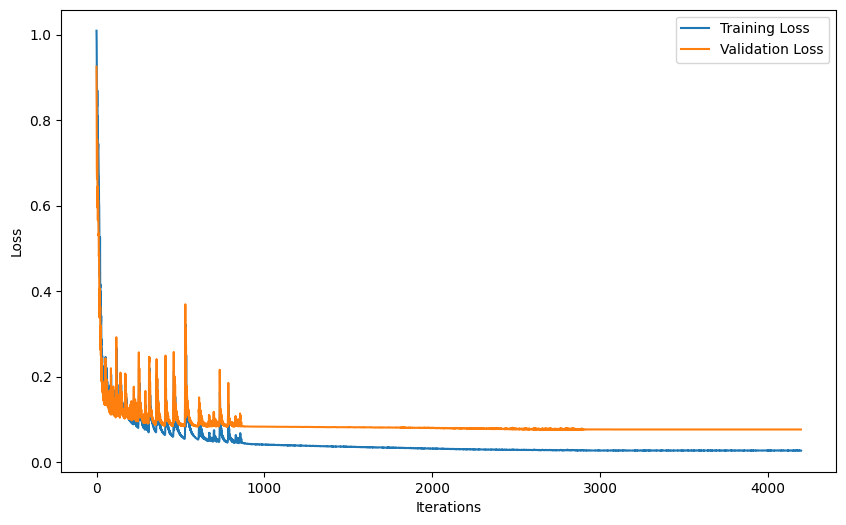

In [355]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ann_figure_Folder/'+prop_tag+'_all_groups_loss.pdf')
plt.show()

In [356]:
with torch.no_grad():
    ys_pred_test = ann(G_test_to).squeeze(-1)
    ys_pred_train = ann(G_train_to).squeeze(-1)
    ys_pred_val = ann(G_val_to).squeeze(-1)
    ys_pred = ann(G_to).squeeze(-1)

In [357]:
y_pred_test = scaler.inverse_transform(ys_pred_test.reshape(-1, 1)).reshape(y_test.size,)
y_pred_train = scaler.inverse_transform(ys_pred_train.reshape(-1, 1)).reshape(y_train.size,)
y_pred_val = scaler.inverse_transform(ys_pred_val.reshape(-1, 1)).reshape(y_val.size,)
y_pred = scaler.inverse_transform(ys_pred.reshape(-1, 1)).reshape(y.size,)

mae_all = mean_absolute_error(y_test, y_pred_test)
r2_all = r2_score(y_test, y_pred_test)

print("MAE on test set:", mae_all)
print("R2 on test set:", r2_all)

MAE on test set: 0.036901571042301975
R2 on test set: 0.9247475084289687


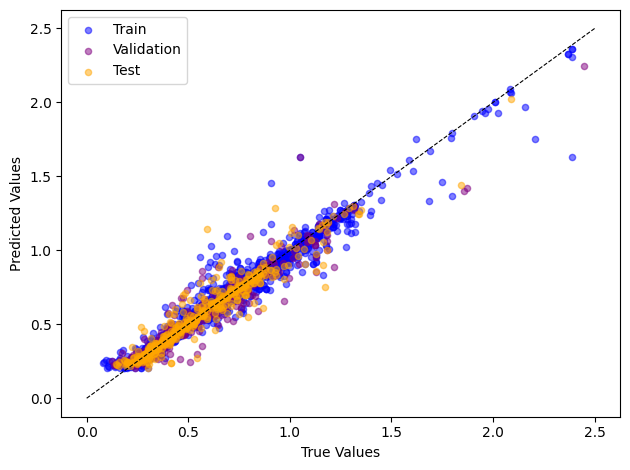

In [365]:
plt.scatter(y_train, y_pred_train, color='blue',s=20, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('ann_figure_Folder/'+prop_tag+'_all_groups_ann_1.pdf')

plt.show()

In [359]:
result = []
for value in y_pred_train:
    if value < 2:
        result.append(value)

print(result)

[0.5374905849259423, 0.5687739804739541, 1.3056390762457837, 0.7492236825268525, 0.3015664726816729, 0.3517530197769853, 0.28285470371138377, 0.6059804988580103, 0.4693948068273542, 1.163067966803779, 0.6802014695924381, 0.7339662624347293, 0.8244788948073121, 0.4322856079668191, 0.8206055056012846, 0.5660590434648881, 0.7523407470076853, 0.47561714542598166, 0.3291062034147202, 1.1412193807684055, 0.45087630410734636, 0.4162036861400766, 0.7562285388128733, 0.2569269344686886, 0.635836043592125, 1.9402767745632894, 0.34643092991596924, 0.37677554330185925, 0.8247854599354119, 0.31290375003236737, 0.3240489299711656, 0.5911037121626541, 0.2812017779656853, 0.6793328422476457, 0.9457486856038291, 0.4135648805170958, 0.9962825738133176, 0.31401996715640956, 0.5360081134706347, 0.5410446792556197, 0.4340146807877086, 0.32763859738719536, 1.2652693124978565, 0.5062012785073055, 0.815316456997166, 0.6819032041464026, 0.34507860743815155, 0.36780473223043425, 0.28161736669026227, 0.376560178

In [366]:
print('MAE on train set',mean_absolute_error(y_train, y_pred_train))
print('R2 on train set',r2_score(y_train, y_pred_train))

MAE on train set 0.019577498275482587
R2 on train set 0.9740590154756514


In [367]:
print('MAE on val set',mean_absolute_error(y_val, y_pred_val))
print('R2 on val set',r2_score(y_val, y_pred_val))

MAE on val set 0.036852166347809565
R2 on val set 0.9214345853690782


In [368]:
print('MAE',mean_absolute_error(y, y_pred))
print('R2',r2_score(y, y_pred))

MAE 0.023036101853586587
R2 0.9643035449294418


In [369]:
print('ARE on train set',np.average(np.abs((y_train - y_pred_train) / y_train))*100)
print('ARE on val set',np.average(np.abs((y_val - y_pred_val) / y_val))*100)
print('ARE on test set',np.average(np.abs((y_test - y_pred_test) / y_test))*100)

print('ARE ',np.average(np.abs((y - y_pred) / y))*100)

ARE on train set 4.075107966280898
ARE on val set 7.2348398104183715
ARE on test set 7.170245641352148
ARE  4.700358453317701


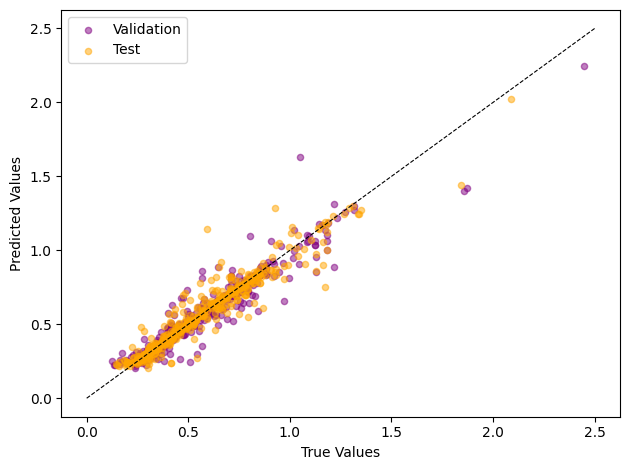

In [371]:
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)
# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('ann_figure_Folder/'+prop_tag+'_all_groups_ann_3.pdf')

plt.show()

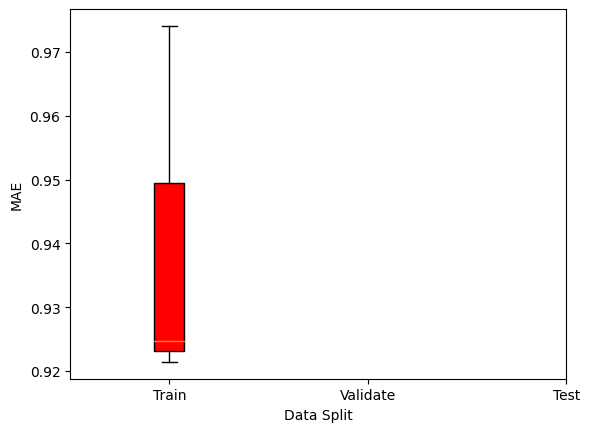

In [377]:
abs_errors_train = r2_score(y_train, y_pred_train)
abs_errors_val = r2_score(y_val, y_pred_val)
abs_errors_test = r2_score(y_test, y_pred_test)

data_MAE = [abs_errors_train, abs_errors_val, abs_errors_test]

colors = ['red', 'green', 'blue']

fig1, ax1 = plt.subplots()
bplot1 = ax1.boxplot(data_MAE, patch_artist=True)

# ax1.yaxis.grid(True)

# ax1.set_ylim(0, 1)

plt.xticks([1, 2, 3], ['Train', 'Validate', 'Test'])

plt.ylabel('MAE')
plt.xlabel('Data Split')

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

plt.show()